# Graph Neural Networks

The biggest difficulty for deep learning with molecules is the choice and computation of "descriptors". Graph neural networks (GNNs) are a category of deep neural networks whose inputs are graphs. As usual, they are composed of specific layers that input a graph and those layers are what we're interested in. You can find reviews of GNNs in X, Y, and Z. Before we dive too deep into them, we must first understand how a graph is represented and how molecules are converted into graphs. 

## Representing a Graph

A graph $\mathbf{G}$ is a set of nodes $\mathbf{V}$ and edges $\mathbf{E}$. In our setting, node $i$ is defined by a vector $\vec{v}_i$, so that the set of nodes can be written as a rank 2 tensor. The edges can be represented as an adjacency matrix $\mathbf{E}$, where if $e_{ij} = 1$ then nodes $i$ and $j$ are connected by an edge. In many fields, graphs are often immediately simplified to be directed and acyclic, which simplifies things. Molecules are instead undirected and have cycles (rings). Thus, our adjacency matrices are always symmetric $e_{ij} = e_{ji}$. Often our edges themselves have features, so that $e_{ij}$ is itself a vector. Then the adjacency matrix becomes a rank 3 tensor. Examples of edge features might be covalent bond order or distance between two nodes.


```{figure} ./methanol.jpg
----
name: methanol
width: 400px
----
Methanol with atoms numbered so that we can convert it to a graph. 
```


Let's see how a graph can be constructed from a molecule. Consider methanol, shown in Figure {numref}`methanol`. I've numbered the atoms so that we have an order for defining the nodes/edges. First, the node features. You can use anything for node features, but often we'll begin with one-hot encoded feature vectors:

| Node | C  | H  | O  |
|:-----|----|----|---:|
| 1    | 0  | 1  |  0 |
| 2    | 0  | 1  |  0 |
| 3    | 0  | 1  |  0 |
| 4    | 1  | 0  |  0 |
| 5    | 0  | 0  |  1 |
| 6    | 0  | 1  |  0 |

$\mathbf{V}$ will be the combined feature vectors of these nodes. The adjacency matrix $\mathbf{E}$ will look like:


|    | 1  | 2  | 3  | 4  | 5  | 6  | 
|:---|----|----|----|----|----|---:|
| 1  | 0  | 0  | 0  | 1  | 0  |  0 |
| 2  | 0  | 0  | 0  | 1  | 0  |  0 |
| 3  | 0  | 0  | 0  | 1  | 0  |  0 |
| 4  | 1  | 1  | 1  | 0  | 1  |  0 |
| 5  | 0  | 0  | 0  | 1  | 0  |  1 |
| 6  | 0  | 0  | 0  | 0  | 1  |  0 |


Take a moment to understand these two. For example, notice that rows 1, 2, and 3 only have the 4th column as non-zero. That's because atoms 1-3 are bonded only to carbon (atom 4). Also, the diagonal is always 0 because atoms cannot be bonded with themselves. 


We'll now begin with a function which can convert a smiles string into this representation.

## Running This Notebook


Click the &nbsp;<i aria-label="Launch interactive content" class="fas fa-rocket"></i>&nbsp; above to launch this page as an interactive Google Colab. See details below on installing packages, either on your own environment or on Google Colab

````{tip} My title
:class: dropdown
To install packages, execute this code in a new cell

**For Google Colab**

```
!wget -c https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
!chmod +x Miniconda3-py37_4.8.3-Linux-x86_64.sh
!time bash ./Miniconda3-py37_4.8.3-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit

import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

!conda install -c conda-forge graphviz
!pip install jupyter-book matplotlib numpy tensorflow pydot seaborn Pillow
```

**For Conda Env**

```
!conda install -c conda-forge graphviz
!pip install jupyter-book matplotlib numpy tensorflow pydot seaborn Pillow
```

````

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import numpy as np
import tensorflow as tf
import warnings
import pandas as pd
import rdkit, rdkit.Chem, rdkit.Chem.rdDepictor, rdkit.Chem.Draw
import networkx as nx
warnings.filterwarnings('ignore')
sns.set_context('notebook')
sns.set_style('dark',  {'xtick.bottom':True, 'ytick.left':True, 'xtick.color': '#666666', 'ytick.color': '#666666',
                        'axes.edgecolor': '#666666', 'axes.linewidth':     0.8 , 'figure.dpi': 300})
color_cycle = ['#1BBC9B', '#F06060', '#5C4B51', '#F3B562', '#6e5687']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=color_cycle) 
soldata = pd.read_csv('https://dataverse.harvard.edu/api/access/datafile/3407241?format=original&gbrecs=true')
np.random.seed(0)
my_elements = {6: 'C', 8: 'O', 1: 'H'}

The hidden cell below defines our function `smiles2graph`. This creates one-hot node feature vectors for the element C, H, and O. It also creates an adjacency tensor with one-hot bond order being the feature vector.

In [2]:
def smiles2graph(sml):
    '''Argument for the RD2NX function should be a valid SMILES sequence
    returns: the graph
    '''
    m = rdkit.Chem.MolFromSmiles(sml)
    m = rdkit.Chem.AddHs(m)
    order_string = {rdkit.Chem.rdchem.BondType.SINGLE: 1,
                    rdkit.Chem.rdchem.BondType.DOUBLE: 2,
                    rdkit.Chem.rdchem.BondType.TRIPLE: 3,
                    rdkit.Chem.rdchem.BondType.AROMATIC: 4}
    N = len(list(m.GetAtoms()))
    nodes = np.zeros((N,len(my_elements)))
    lookup = list(my_elements.keys())
    for i in m.GetAtoms():
        nodes[i.GetIdx(), lookup.index(i.GetAtomicNum())] = 1
    
    adj = np.zeros((N,N,5))
    for j in m.GetBonds():
        u = min(j.GetBeginAtomIdx(),j.GetEndAtomIdx())
        v = max(j.GetBeginAtomIdx(),j.GetEndAtomIdx())        
        order = j.GetBondType()
        if order in order_string:
            order = order_string[order]
        else:
            raise Warning('Ignoring bond order' + order)
        adj[u, v, order] = 1        
        adj[v, u, order] = 1        
    return nodes, adj

In [3]:
nodes, adj = smiles2graph('CO')
nodes

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

## A Graph Neural Network

A graph neural network (GNN) is a neural network with two defining attributes:

1. It's input is a graph
2. It's output is permutation invariant

We can understand clearly the first point. Here, a graph permutation means re-ordering our nodes. In our methanol example above, we could have easily made the carbon be atom 1 instead of atom 4. Our new adjacency matrix would then be:

|    | 1  | 2  | 3  | 4  | 5  | 6  | 
|:---|----|----|----|----|----|---:|
| 1  | 0  | 1  | 1  | 1  | 1  |  0 |
| 2  | 1  | 0  | 0  | 0  | 0  |  0 |
| 3  | 1  | 0  | 0  | 0  | 0  |  0 |
| 4  | 1  | 0  | 0  | 0  | 1  |  0 |
| 5  | 1  | 0  | 0  | 0  | 0  |  1 |
| 6  | 0  | 0  | 0  | 0  | 1  |  0 |


```{margin}
Ok, so technically we might want our GNN to be permutation *equivariant*. If our GNN outputs per-node features, then obviously if we swap the node order of input, we want our per-node output to swap.
```

A GNN is permutation invariant if the output is insensitive to these kind of exchanges. Of course, there may exist GNNs out there which are not permutation invariant, especially if they are for trees where it is possible to deterministically order all nodes. Yet all the GNNs used in chemistry and most of the deep learning work is concerned with GNNs that are permutation invariant.

### A simple GNN

We will often mention a GNN when we really mean a layer from a GNN. Most GNNs implement a specific layer that can deal with graphs, and so usually we are only concerned with this layer. Let's see an example of a simple layer for a GNN:

\begin{equation}
f_k = \sigma\left( \sum_i \sum_jn_{ij}w_{jk}  \right)
\end{equation}

This equation shows that we first multiply every node feature by trainable weights $w_{jk}$, sum over all node features, and then apply an activation. This will yield a single feature vector for the graph. Is this equation permutation invariant? Yes, because the node index in our expression is index $i$ which can be re-ordered without affecting the output.

Let's see an example that is similar, but not permutation invariant:

\begin{equation}
f_k = \sigma\left( \sum_i n_{ij}w_{ik}  \right)
\end{equation}

This is a small change. We have one weight vector per node now. This makes the trainable weights depend on the ordering of the nodes. Then if we swap the node ordering, our weights will no longer align. So if we were to input two methanol molecules, which should have the same output, but we switched two atom numbers, we would get different answers. These simple examples differ from real GNNs in two important ways: (i) they give a single feature vector output, which throws away per-node information, and (ii) they do not use the adjacency matrix. Let's see a real GNN that has these properties while maintaining permutation invariance.

## Kipf & Welling GCN

One of the first popular GNNs is the Kipf & Welling graph convolutional network (GCN) {cite}`kipf2016semi`. Although some people consider GCNs to be a broad class of GNNs, we'll use GCNs to refer specifically the Kipf & Welling GCN. 
Thomas Kipf has written an [excellent article introducing the GCN](https://tkipf.github.io/graph-convolutional-networks/). I will not repeat this article, so please take a look at it.

The input to a GCN layer is $\mathbf{V}$, $\mathbf{E}$ and it outputs an updated $\mathbf{V}'$. Each node feature vector is updated. The way it updates a node feature vector is by averaging the feature vectors of its neigbhors, as determined by $\mathbf{E}$. The choice of averaging over neigbhors is what makes a GCN layer permutation invariant. Averaging over neighbors is not trainable, so we must add trainable parameters. We multiply the neighbor features by a trainable matrix before the averaging, which gives the GCN the ability to learn. In Einstein notation, this process is:

\begin{equation}
v_{il} = \sigma\left(\frac{1}{d_i}e_{ij}v_{jk}w_{lk}\right)
\end{equation}

where $i$ is the node we're considering, $j$ is the neighbor index, $k$ is the node input feature, $l$ is the ouput node feature, $d_i$ is the degree of node i (which makes it an average instead of sum), $e_{ij}$ isolates neighbors so that all non-neighbor $v_{jk}$s are zero, $\sigma$ is our activation, and $w_{lk}$ is the trainable weights. This equation is a mouthful, but it truly just is the average over neighbors with a trainable matrix thrown in. One common modification is to make all nodes neighbors of themselves. This is so that the output node features $v_{il}$ depends on the input features $v_{ik}$. We do not need to change our equation, just make the adjacency matrix have $1$s on the diagonal instead of $0$ by adding the identity matrix during pre-processing.

Building understanding about the GCN is important for understanding other GNNs. You can view the GCN layer as a way to "communicate" between a node and its neigbhors. The output for node $i$ will depend only on its immediate neigbhors. For chemistry, this is not satisfactory. So you can stack multiple layers. If you have two layers, then the output for node $i$ will include information about node $i$'s neighbors' neigbhors. Another important detail to understand in GCNs is that the averaging procedure accomplishes two goals: (i) it gives permutation invariance by removing the effect of neighbor order and (ii) it prevents a change in magnitude in node features. A sum would accomplish (i) but would cause the magnitude of the node features to grow after each layer. Of course, you could ad-hoc put a batch normalization layer after each GCN layer to keep output magnitudes stable but averaging is easy.

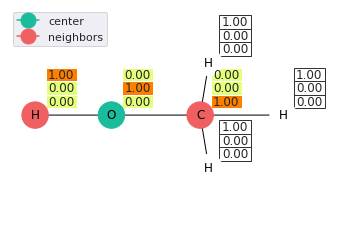

In [4]:
from myst_nb import glue
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage

def draw_vector(x, y, s, v, ax, cmap, **kwargs):
    x += s / 2
    y += s /2 
    for vi in v:        
        if cmap is not None:
            ax.add_patch(mpl.patches.Rectangle((x, y), s * 1.5, s, facecolor=cmap(vi),**kwargs))
        else:
            ax.add_patch(mpl.patches.Rectangle((x, y), s * 1.5, s, facecolor='#FFF', edgecolor='#333',**kwargs))
        ax.text(x + s * 1.5 / 2, y + s/2, '{:.2f}'.format(vi), verticalalignment='center', horizontalalignment='center')
        y += s        
def draw_key(x, y, s, v, ax, cmap, **kwargs):    
    x += s / 2    
    y += s /2     
    for vi in v:        
        ax.add_patch(mpl.patches.Rectangle((x, y), s * 1.5, s, facecolor=cmap(1.),**kwargs))
        ax.text(x + s * 1.5 / 2, y + s/2, vi, verticalalignment='center', horizontalalignment='center')
        y += s
    ax.text(x,y + s/2, 'Key:', verticalalignment='center', horizontalalignment='left')
def draw(nodes, adj, ax, highlight=None, key=False, labels=None, mask=None, draw_nodes=None):    
    G = nx.Graph()
    for i in range(adj.shape[0]):
        for j in range(adj.shape[0]):
            if np.any(adj[i, j]):
                G.add_edge(i, j)
    if mask is None:
        mask = [True] * len(G)
    if draw_nodes is None:
        draw_nodes = nodes
    # go from atomic number to element
    elements = np.argmax(draw_nodes, axis=-1)
    el_labels = {i: list(my_elements.values())[e] for i,e in enumerate(elements)}
    pos = nx.nx_agraph.graphviz_layout(G, prog='sfdp')
    pos = nx.rescale_layout_dict(pos)
    c = ['white'] * len(G)    
    all_h = []
    if highlight is not None:        
        for i,h in enumerate(highlight):
            for hj in h:
                c[hj] = 'C{}'.format(i)                
                all_h.append(hj)
    nx.draw(G, ax=ax, pos=pos, labels=el_labels, node_size=700, node_color=c)
    cmap = plt.get_cmap('Wistia')    
    for i in range(len(G)):
        if not mask[i]:
            continue
        if i in all_h:
            draw_vector(*pos[i], 0.15, nodes[i], ax, cmap)
        else:
            draw_vector(*pos[i], 0.15, nodes[i], ax, None)
    if key:
        draw_key(-1, -1, 0.15, my_elements.values(), ax, cmap)
    if labels is not None:
        legend_elements = []
        for i,l in enumerate(labels):
            p = mpl.lines.Line2D([0], [0], marker='o', color='C{}'.format(i), label=l,
                          markersize=15)
            legend_elements.append(p)        
        ax.legend(handles=legend_elements)
    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(-1.2, 1.2)
    
plt.figure()
draw(nodes, adj, plt.gca(), highlight=[[1], [5, 0]], labels=['center', 'neighbors'])
glue('dframe', plt.gcf(), display=False)

[0] 0 5 0
[False, False, False, False, False, True] 5


t:   0%|          | 0/48 [00:00<?, ?it/s, now=None]

MoviePy - Building file gcn.gif with imageio.
[0] 0 5 0.0
[False, False, False, False, False, True] 5


t:   4%|▍         | 2/48 [00:00<00:15,  2.95it/s, now=None]

[0] 0 5 0.5
[False, False, False, False, False, True] 5


t:   6%|▋         | 3/48 [00:01<00:17,  2.60it/s, now=None]

[0] 0 5 1.0
[False, False, False, False, False, True] 5


t:   8%|▊         | 4/48 [00:01<00:18,  2.37it/s, now=None]

[0] 0 5 1.5
[False, False, False, False, False, True] 5


t:  10%|█         | 5/48 [00:02<00:19,  2.23it/s, now=None]

[0] 0 1 2.0
[False, True, False, False, False, True] 1


t:  12%|█▎        | 6/48 [00:02<00:19,  2.15it/s, now=None]

[0] 0 1 2.5
[False, True, False, False, False, True] 1


t:  15%|█▍        | 7/48 [00:03<00:19,  2.09it/s, now=None]

[0] 0 1 3.0
[False, True, False, False, False, True] 1


t:  17%|█▋        | 8/48 [00:03<00:19,  2.03it/s, now=None]

[0] 0 1 3.5
[False, True, False, False, False, True] 1


t:  19%|█▉        | 9/48 [00:04<00:20,  1.91it/s, now=None]

[0] 0 0 4.0
[True, True, False, False, False, True] 0


t:  21%|██        | 10/48 [00:04<00:20,  1.89it/s, now=None]

[0] 0 0 4.5
[True, True, False, False, False, True] 0


t:  23%|██▎       | 11/48 [00:05<00:19,  1.88it/s, now=None]

[0] 0 0 5.0
[True, True, False, False, False, True] 0


t:  25%|██▌       | 12/48 [00:05<00:19,  1.88it/s, now=None]

[0] 0 0 5.5
[True, True, False, False, False, True] 0


t:  27%|██▋       | 13/48 [00:06<00:19,  1.83it/s, now=None]

[0] 0 2 6.0
[True, True, True, False, False, True] 2


t:  29%|██▉       | 14/48 [00:07<00:18,  1.81it/s, now=None]

[0] 0 2 6.5
[True, True, True, False, False, True] 2


t:  31%|███▏      | 15/48 [00:07<00:20,  1.62it/s, now=None]

[0] 0 2 7.0
[True, True, True, False, False, True] 2


t:  33%|███▎      | 16/48 [00:08<00:19,  1.66it/s, now=None]

[0] 0 2 7.5
[True, True, True, False, False, True] 2


t:  35%|███▌      | 17/48 [00:08<00:18,  1.71it/s, now=None]

[0] 0 3 8.0
[True, True, True, True, False, True] 3


t:  38%|███▊      | 18/48 [00:09<00:17,  1.76it/s, now=None]

[0] 0 3 8.5
[True, True, True, True, False, True] 3


t:  40%|███▉      | 19/48 [00:10<00:16,  1.81it/s, now=None]

[0] 0 3 9.0
[True, True, True, True, False, True] 3


t:  42%|████▏     | 20/48 [00:10<00:15,  1.82it/s, now=None]

[0] 0 3 9.5
[True, True, True, True, False, True] 3


t:  44%|████▍     | 21/48 [00:11<00:15,  1.78it/s, now=None]

[0] 0 4 10.0
[True, True, True, True, True, True] 4


t:  46%|████▌     | 22/48 [00:11<00:14,  1.79it/s, now=None]

[0] 0 4 10.5
[True, True, True, True, True, True] 4


t:  48%|████▊     | 23/48 [00:12<00:14,  1.78it/s, now=None]

[0] 0 4 11.0
[True, True, True, True, True, True] 4


t:  50%|█████     | 24/48 [00:12<00:13,  1.74it/s, now=None]

[0] 0 4 11.5
[True, True, True, True, True, True] 4


t:  52%|█████▏    | 25/48 [00:13<00:13,  1.73it/s, now=None]

recomputing
[1] 1 5 0.0
[False, False, False, False, False, True] 5


t:  54%|█████▍    | 26/48 [00:14<00:13,  1.58it/s, now=None]

[1] 1 5 0.5
[False, False, False, False, False, True] 5


t:  56%|█████▋    | 27/48 [00:14<00:12,  1.65it/s, now=None]

[1] 1 5 1.0
[False, False, False, False, False, True] 5


t:  58%|█████▊    | 28/48 [00:15<00:12,  1.67it/s, now=None]

[1] 1 5 1.5
[False, False, False, False, False, True] 5


t:  60%|██████    | 29/48 [00:15<00:11,  1.70it/s, now=None]

[1] 1 1 2.0
[False, True, False, False, False, True] 1


t:  62%|██████▎   | 30/48 [00:16<00:10,  1.73it/s, now=None]

[1] 1 1 2.5
[False, True, False, False, False, True] 1


t:  65%|██████▍   | 31/48 [00:16<00:09,  1.77it/s, now=None]

[1] 1 1 3.0
[False, True, False, False, False, True] 1


t:  67%|██████▋   | 32/48 [00:17<00:09,  1.77it/s, now=None]

[1] 1 1 3.5
[False, True, False, False, False, True] 1


t:  69%|██████▉   | 33/48 [00:18<00:08,  1.80it/s, now=None]

[1] 1 0 4.0
[True, True, False, False, False, True] 0


t:  71%|███████   | 34/48 [00:18<00:07,  1.83it/s, now=None]

[1] 1 0 4.5
[True, True, False, False, False, True] 0


t:  73%|███████▎  | 35/48 [00:19<00:07,  1.84it/s, now=None]

[1] 1 0 5.0
[True, True, False, False, False, True] 0


t:  75%|███████▌  | 36/48 [00:19<00:06,  1.82it/s, now=None]

[1] 1 0 5.5
[True, True, False, False, False, True] 0


t:  77%|███████▋  | 37/48 [00:20<00:06,  1.80it/s, now=None]

[1] 1 2 6.0
[True, True, True, False, False, True] 2


t:  79%|███████▉  | 38/48 [00:20<00:05,  1.81it/s, now=None]

[1] 1 2 6.5
[True, True, True, False, False, True] 2


t:  81%|████████▏ | 39/48 [00:21<00:05,  1.63it/s, now=None]

[1] 1 2 7.0
[True, True, True, False, False, True] 2


t:  83%|████████▎ | 40/48 [00:22<00:04,  1.68it/s, now=None]

[1] 1 2 7.5
[True, True, True, False, False, True] 2


t:  85%|████████▌ | 41/48 [00:22<00:04,  1.72it/s, now=None]

[1] 1 3 8.0
[True, True, True, True, False, True] 3


t:  88%|████████▊ | 42/48 [00:23<00:03,  1.72it/s, now=None]

[1] 1 3 8.5
[True, True, True, True, False, True] 3


t:  90%|████████▉ | 43/48 [00:23<00:02,  1.74it/s, now=None]

[1] 1 3 9.0
[True, True, True, True, False, True] 3


t:  92%|█████████▏| 44/48 [00:24<00:02,  1.74it/s, now=None]

[1] 1 3 9.5
[True, True, True, True, False, True] 3


t:  94%|█████████▍| 45/48 [00:24<00:01,  1.74it/s, now=None]

[1] 1 4 10.0
[True, True, True, True, True, True] 4


t:  96%|█████████▌| 46/48 [00:25<00:01,  1.74it/s, now=None]

[1] 1 4 10.5
[True, True, True, True, True, True] 4


t:  98%|█████████▊| 47/48 [00:26<00:00,  1.76it/s, now=None]

[1] 1 4 11.0
[True, True, True, True, True, True] 4


t: 100%|██████████| 48/48 [00:26<00:00,  1.75it/s, now=None]

[1] 1 4 11.5
[True, True, True, True, True, True] 4


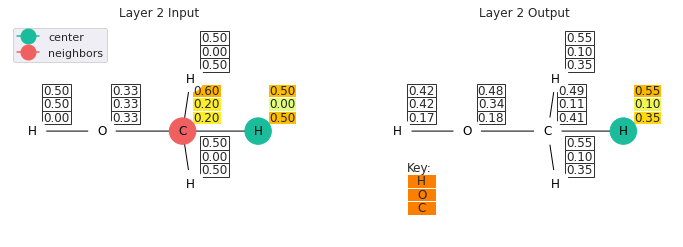

In [5]:
fig, axs = plt.subplots(1,2, squeeze=True, figsize=(12, 4))
order = [5, 1, 0, 2, 3, 4]
time_per_node = 2
last_layer = [0]
layers = 2
input_nodes = np.copy(nodes)
def make_frame(t):
    axs[0].clear()
    axs[1].clear()    
    
    layer_i = int(t / (time_per_node * len(order)))
    axs[0].set_title(f'Layer {layer_i + 1} Input')
    axs[1].set_title(f'Layer {layer_i + 1} Output')    

    flat_adj = np.sum(adj, axis=-1)
    out_nodes = np.einsum('i,ij,jk->ik', 1/(np.sum(flat_adj, axis=1) + 1), flat_adj + np.eye(*flat_adj.shape), nodes)
    
        
    if last_layer[0] != layer_i:
        print('recomputing')
        nodes[:] = out_nodes
        last_layer[0] = layer_i
        
        
    t -= layer_i * time_per_node * len(order)
    i = order[int(t / time_per_node)]    
    print(last_layer, layer_i, i, t)
    mask = [False] * nodes.shape[0]
    for j in order[:int(t / time_per_node) + 1]:
        mask[j] = True    
    print(mask, i)
    neighs = list(np.where(adj[i])[0])
    if (t - int(t / time_per_node) * time_per_node) >= time_per_node / 4:
        draw(nodes, adj, axs[0], highlight=[[i], neighs], labels=['center', 'neighbors'], draw_nodes=input_nodes)    
    else:
        draw(nodes, adj, axs[0], highlight=[[i]], labels=['center', 'neighbors'], draw_nodes=input_nodes)    
    if (t - int(t / time_per_node) * time_per_node) < time_per_node / 2:
        mask[j] = False            
    draw(out_nodes, adj, axs[1], highlight=[[i]], key=True, mask=mask, draw_nodes=input_nodes)
    return mplfig_to_npimage(fig)

animation = VideoClip(make_frame, duration=time_per_node * nodes.shape[0] * layers)

animation.write_gif('gcn.gif', fps=2)

```{glue:figure} dframe
----
name: dframe
----
Intermediate step of the graph convolution layer. The center node is being updated by averaging its neighbors features.
```


```{figure} ./gcn.gif
----
name: gcnanim
----
Animation of the graph convolution layer. The left is input, right is output node features. Note that two layers are shown (see title change).
```

To help understand the GCN layer, look at {numref}`dframe`. It shows an intermediate step of the GCN layer. Each node feature is represented here as a one-hot encoded vector at input. The animation in {numref}`gcnanim` shows the averaging process over neighbor features.  To make this animation easy to follow, the trainable weights and activation functions are not considered. Note that the animation repeats for a second layer. Watch how the "information" about there being an oxygen atom in the molecule is propogated only after two layers to each atom. All GNNs operate with similair approaches, so try to understand how this animation works. 


### GCN Implementation

Let's now create a tensor implementation of the GCN. We'll skip the activation and trainable weights for now.
We must first compute our rank 2 adjacency matrix. The `smiles2graph` code above computes an adjacency tensor with feature vectors. We can fix that with a simple reduction and add the identity at the same time


In [6]:
nodes, adj = smiles2graph('CO')
adj_mat = np.sum(adj, axis=-1) + np.eye(adj.shape[0])
adj_mat

array([[1., 1., 1., 1., 1., 0.],
       [1., 1., 0., 0., 0., 1.],
       [1., 0., 1., 0., 0., 0.],
       [1., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 1.]])

To compute degree of each node, we can do another reduction:

In [7]:
degree = np.sum(adj_mat, axis=-1)
degree

array([5., 3., 2., 2., 2., 2.])

Now we can put all these pieces together into the Einstein equation

In [8]:
print(nodes[0])
# note to divide by degree, make the input 1 / degree
new_nodes = np.einsum('i,ij,jk->ik', 1 / degree, adj_mat, nodes)
print(new_nodes[0])

[1. 0. 0.]
[0.2 0.2 0.6]


To now implement this as a layer in Keras, we must put this code above into a new Layer subclass. The code is relatively straightforward, but you can read-up on the function names and Layer class in [this tutorial](https://keras.io/guides/making_new_layers_and_models_via_subclassing/). The three main changes are that we create trainable parameters `self.w` and use them in the `einsum`, we use an activation `self.activation`, and we output both our new node features and the adjacency matrix. The reason to output the adjacency matrix is so that we can stack multiple GCN layers without having to pass the adjacency matrix each time. 

In [9]:
class GCNLayer(tf.keras.layers.Layer):
    '''Implementation of GCN as layer'''
    def __init__(self, activation=None,**kwargs):
        # constructor, which just calls super constructor
        # and turns requested activation into a callable function
        super(GCNLayer, self).__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)
    
    def build(self, input_shape):
        # create trainable weights
        node_shape, adj_shape = input_shape
        self.w = self.add_weight(shape=(node_shape[2], node_shape[2]),
                                name='w')
        
    def call(self, inputs):
        # split input into nodes, adj
        nodes, adj = inputs 
        # compute degree
        degree = tf.reduce_sum(adj, axis=-1)
        # GCN equation
        new_nodes = tf.einsum('bi,bij,bjk,kl->bil', 1 / degree, adj, nodes, self.w)
        out = self.activation(new_nodes)
        return out, adj

We can now try our our layer:

In [10]:
gcnlayer = GCNLayer('relu')
# we insert a batch axis here
gcnlayer((nodes[np.newaxis,...], adj_mat[np.newaxis,...]))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



(<tf.Tensor: shape=(1, 6, 3), dtype=float32, numpy=
 array([[[0.7190935 , 0.        , 0.22116695],
         [0.54619783, 0.        , 0.38474584],
         [0.45868695, 0.        , 0.17285526],
         [0.45868695, 0.        , 0.17285526],
         [0.45868695, 0.        , 0.17285526],
         [0.84982824, 0.        , 0.3921628 ]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 6, 6), dtype=float32, numpy=
 array([[[1., 1., 1., 1., 1., 0.],
         [1., 1., 0., 0., 0., 1.],
         [1., 0., 1., 0., 0., 0.],
         [1., 0., 0., 1., 0., 0.],
         [1., 0., 0., 0., 1., 0.],
         [0., 1., 0., 0., 0., 1.]]], dtype=float32)>)

It outputs (1) the new node features and (2) the adjacency matrix. Let's make sure we can stack these and apply the GCN multiple times

In [11]:
x = (nodes[np.newaxis,...], adj_mat[np.newaxis,...])
for i in range(2):
    x = gcnlayer(x)

It works! Why do we see zeros though? Probably because we had negative numbers that were removed by our ReLU activation. This will be solved by training and increasing our dimension number. 

## Solubility Example

We'll now revisit predicting solubility with GCNs. Remember before that we used the features included with the dataset. Now, however we can use the molecular structures directly. Our GCN layer outputs node-level features. To predict solubility, we need to get a graph-level feature. We'll see later how to be more sophisticated in this process, but for now let's just take the average over all node features after our GCN layers. This is simple, permutation invariant, and gets us from node-level to graph level. Here's an implementation of this

In [12]:
class GRLayer(tf.keras.layers.Layer):
    '''A GNN layer that computes average over all node features'''
    def __init__(self, name='GRLayer', **kwargs):
        super(GRLayer, self).__init__(name=name, **kwargs)
    
    def call(self, inputs):
        nodes, adj = inputs
        reduction = tf.reduce_mean(nodes, axis=1)
        return reduction
    

To complete our deep solubility predictor, we can add some dense layers and make sure we have a single-output without activation since we're doing regression. Note this model is defined using the [Keras functional API](https://keras.io/guides/functional_api/) which is necessary when you have multiple inputs. 

In [13]:
ninput = tf.keras.Input((None,100,))
ainput = tf.keras.Input((None,None,))
# GCN block
x = GCNLayer('relu')([ninput, ainput])
x = GCNLayer('relu')(x)
x = GCNLayer('relu')(x)
x = GCNLayer('relu')(x)
# reduce to graph features
x = GRLayer()(x)
# standard layers
x = tf.keras.layers.Dense(16, 'tanh')(x)
x = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs=(ninput, ainput), outputs=x)

where does the 100 come from? Well, this dataset has lots of elements so we cannout use our size 3 one-hot encondings because we'll have more than 3 unique elements. We previously only had C, H and O. This is a good time to updaet our `smiles2graph` function to deal with this

In [14]:
def gen_smiles2graph(sml):
    '''Argument for the RD2NX function should be a valid SMILES sequence
    returns: the graph
    '''
    m = rdkit.Chem.MolFromSmiles(sml)
    m = rdkit.Chem.AddHs(m)
    order_string = {rdkit.Chem.rdchem.BondType.SINGLE: 1,
                    rdkit.Chem.rdchem.BondType.DOUBLE: 2,
                    rdkit.Chem.rdchem.BondType.TRIPLE: 3,
                    rdkit.Chem.rdchem.BondType.AROMATIC: 4}
    N = len(list(m.GetAtoms()))
    nodes = np.zeros((N,100))
    for i in m.GetAtoms():
        nodes[i.GetIdx(), i.GetAtomicNum()] = 1
    
    adj = np.zeros((N,N))
    for j in m.GetBonds():
        u = min(j.GetBeginAtomIdx(),j.GetEndAtomIdx())
        v = max(j.GetBeginAtomIdx(),j.GetEndAtomIdx())        
        order = j.GetBondType()
        if order in order_string:
            order = order_string[order]
        else:
            raise Warning('Ignoring bond order' + order)
        adj[u, v] = 1        
        adj[v, u] = 1
    adj += np.eye(N)
    return nodes, adj

In [15]:
nodes, adj = gen_smiles2graph('CO')
model((nodes[np.newaxis,...], adj_mat[np.newaxis,...]))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.03093036]], dtype=float32)>

It outputs one number! That's always nice to have. Now we need to do some work to get a trainable dataset. Our dataset is a little bit complex because our features are tuples of tensors($\mathbf{V}, \mathbf{E}$) so that our dataset is a tuple of tuples: $\left((\mathbf{V}, \mathbf{E}), y\right)$. We use a **generator**, which is just a python function that can return multiple times. Our function returns once for every training example. Then we have to pass it to the `from_generator` dataset constructor which requires explicit declaration of the shapes of these examples. 

In [16]:
def example():
    for i in range(len(soldata)):
        graph = gen_smiles2graph(soldata.SMILES[i])        
        sol = soldata.Solubility[i]
        yield graph, sol
data = tf.data.Dataset.from_generator(example, output_types=((tf.float32, tf.float32), tf.float32), 
                                      output_shapes=((tf.TensorShape([None, 100]), tf.TensorShape([None, None])), tf.TensorShape([])))

Whew, that's a lot. Now we can do our usual splitting of the dataset.

In [17]:
test_data = data.take(200)
val_data = data.skip(200).take(200)
train_data = data.skip(400)

And finally, time to train.

In [20]:
model.compile('adam', loss='mean_squared_error')
result = model.fit(train_data.batch(1), validation_data=val_data.batch(1),  epochs=20, verbose=0)

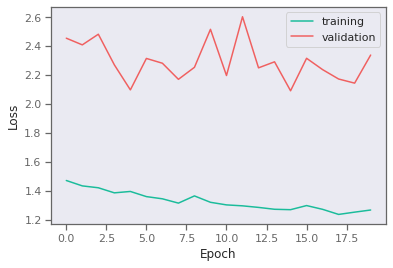

In [21]:
plt.plot(result.history['loss'], label='training')
plt.plot(result.history['val_loss'], label='validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

This model is definitely underfit. One reason is that our batch size is 1. This is an side-effect of making the number of atoms variable and then tensorflow has trouble batching together our data if there are two unknown dimensions. You can fix this by manually batching or padding all molecules to have as many atoms as the one with the max. In any case, this example shows how to use GCN layers in a complete model.

## Message Passing Viewpoint

One way to more broadly view a GCN layer is that it is a kind of "message-passing" layer. You first compute a message coming from each neighboring node:

\begin{equation}
\vec{e}_{{s_i}j} = \vec{n}_{{s_i}j} \mathbf{W}
\end{equation}

where $n_{{s_i}j}$ means the $j$th neigbhor of node $i$. The $s_i$ means senders to $i$. This is how a GCN computes the messages, it's just a weight matrix times each neighbor node features. After getting the messages that will go to $\vec{e}_{{s_i}j}$, we aggregate them using a function which is permutation invariant to the order of neigbhors:

\begin{equation}
\vec{e}_{i} = \frac{1}{|\vec{e}_{{s_i}j}|}\sum \vec{e}_{{s_i}j} 
\end{equation}

In the GCN this aggregation is just a mean. Finally, we update our node using the aggregated message in the GCN:

\begin{equation}
\vec{n}^{'}_{i} = \sigma(\vec{e}_i)
\end{equation}

where $n^{'}$ indicates the new node features. This is simply the activated aggregated message. Writing it out this way, you can see how it is possible to make small changes. One important paper by Gilmer et al. explored some of these choices and described how this general idea of message passing layers does well in learning to predict molecular energies from quantum mechanics {cite}`gilmer2017neural`. Examples of changes to the above GCN equations are to include edge information when computing the neighbor messages or use a dense neural network layer in place of $\sigma$. 

## Gated Graph Neural Network


One important variant of the message passing layer is the **gated graph neural network** (GGN) {cite}`li2015gated`. It replaces the last equation, the node update, with

\begin{equation}
\vec{n}^{'}_{i} = \textrm{GRU}(\vec{n}_i, \vec{e}_i)
\end{equation}

where the $\textrm{GRU}(\cdot, \cdot)$ is a gated recurrent unit{cite}`chung2014empirical`. The interesting property of a GRU is that it has trainable parameters, giving the model a bit more flexibility, but the GRU parameters do not change as you stack more layers. A GRU is usually used for modeling sequences of undetermined length, like a sentence. What's nice about this is that you can stack infinite GGN layers without increasing the number of trainable parameters (assuming you make $\mathbf{W}$ the same at each layer). Thus GGNs are suited for large graphs, like a large protein or large unit cell. 


## Battaglia General Equations

As you can see, message passing layers is a general way to view GNN layers. Battaglia et al {cite}`battaglia2018relational` went further and created a general set of equations which captures nearly all GNNs. They broke the GNN layer equations down into 3 update equations, like the node update equation we saw in the message passing layer equations, and 3 aggregation equations. There is a new concept in these equations: graph feature vectors. A graph feature vector is a set of features which represent the whole graph or molecule. For example, when computing solubility it may have been useful to build-up a per-molecule feature vector that is eventually used to compute solubility. Any knid of per-molecule quantity like energy can be expressed as a graph-level feature vector. 

The first step in these equations is updating the edge feature vectors, written as $\vec{e}_k$, which we haven't seen yet but is certainly possible:

\begin{equation}
\vec{e}^{'}_k = \phi^e\left( \vec{e}_k, \vec{v}_{rk}, \vec{v}_{sk}, \vec{u}\right)
\end{equation}

where $\vec{e}_k$ is the feature vector of edge $k$, $\vec{v}_{rk}$ is the receiving node feature vector for edge $k$, $\vec{v}_{sk}$ is the sending node feature vector for edge $k$, $\vec{u}$ is the global graph feature vector, and $\phi^e$ is one of the three update functions that the define the GNN layer. Note that these are meant to be general expressions and you define $\phi^e$ for your specific GNN layer. The output edge updates are then aggregated with the first aggregation function:

\begin{equation}
\bar{e}^{'}_i = \rho^{e\rightarrow v}\left( E_i^{'}\right)
\end{equation}

where $\rho^{e\rightarrow v}$ is our defined function and $E_i^{'}$ represents all edges in or out of node i. Having our aggregated edge, which is equivalent to our *message* previously, we can compute the node update:

\begin{equation}
\vec{v}^{'}_i = \phi^v\left( \bar{e}^{'}_i, \vec{v}_i, \vec{u}\right)
\end{equation}

This concludes the usual steps of a GNN layer. If you are updating global attributes or aggregating nodes or edges, the following additional steps may be defined:

\begin{equation}
\bar{e}^{'} = \rho^{e\rightarrow u}\left( E^{'}\right)
\end{equation}

This equation aggregates all messages across the whole graph. Then we can aggregate the new nodes across the whole graph:

\begin{equation}
\bar{v}^{'} = \rho^{v\rightarrow u}\left( V^{'}\right)
\end{equation}

Then, we can compute the update to the global feature vector as:
\begin{equation}
\vec{u}^{'} = \phi^u\left( \bar{e}^{'},\bar{v}^{'}, \vec{u}\right)
\end{equation}


### Reformulating GCN into Battaglia equations

Let's see how the GCN is presented in this form. We first compute our neighbor messages for all possible neighbors. Since our graph is undirected, we'll just by convention use the senders as the "neighbor"

\begin{equation}
\vec{e}^{'}_k = \phi^e\left( \vec{e}_k, \vec{v}_{rk}, \vec{v}_{sk}, \vec{u}\right) = \vec{v}_{sk} \mathbf{W}
\end{equation}

To aggregate our messages, we average them.

\begin{equation}
\bar{e}^{'}_i = \rho^{e\rightarrow v}\left( E_i^{'}\right) = \frac{1}{|E_i^{'}|}\sum E_i^{'}
\end{equation}

Our node update is then the activation:

\begin{equation}
\vec{v}^{'}_i = \phi^v\left( \bar{e}^{'}_i, \vec{v}_i, \vec{u}\right) = \sigma(\bar{e}^{'}_i)
\end{equation}

we could include the self-loop above using $\sigma(\bar{e}^{'}_i + \vec{v}_i)$. The other functions are not used so that is the complete set. 

## Cited References

```{bibliography} references.bib
```